In [1]:
import numpy as np
#import mosek
#import cvxpy as cp
import matplotlib.pyplot as plt
import time

%matplotlib inline

#from itertools import combinations 

#from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import normalized_mutual_info_score as NMI_score, adjusted_rand_score as ARI_score, rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabasz_score, mean_squared_error # cohen_kappa_score, hinge_loss, coverage_error, consensus_score
#from sklearn.utils import shuffle
#from sklearn.model_selection import train_test_split

#%load_ext line_profiler



In [2]:
cd ../..

/Users/logang/Dropbox/GrosenickLab/Code/PCMF


In [3]:
import scipy.io
from sklearn import preprocessing

data_path = '/Users/logang/Dropbox/GrosenickLab/Code/clusterCCA/data/'

mat = scipy.io.loadmat(data_path+'data1_iqr_maxgrp_nonzero_z.mat',matlab_compatible=True)
data1_iqr_maxgrp = mat['data1_iqr_maxgrp_nonzero_z']
print("data1_iqr_maxgrp shape:", data1_iqr_maxgrp.shape)

mat = scipy.io.loadmat(data_path+'clinical_data1_symp_mat.mat',matlab_compatible=False)
clinical_data1 = mat['clinical_data1_symp_mat']
print("clinical_data1 shape:", clinical_data1.shape)

mat = scipy.io.loadmat(data_path+'mode_clusters_new.mat',matlab_compatible=False)
mode_clusters_new = np.squeeze(mat['mode_clusters_new'])

mat = scipy.io.loadmat(data_path+'data1_iqr_select.mat',matlab_compatible=True)
data1_iqr_select = mat['data1_iqr_select']
print("data1_iqr_select shape:", data1_iqr_select.shape)

mat = scipy.io.loadmat(data_path+'X_t.mat',matlab_compatible=True)
data1_iqr_ica = mat['X_t']
print("data1_iqr_ica shape:", data1_iqr_ica.shape)

clusters = np.sort(mode_clusters_new).T
order = np.argsort(mode_clusters_new)
order = order[0]

#X = data1_iqr_ica # was ica 
X = data1_iqr_select # was ica 
Y = clinical_data1

scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)#[:,0:10]
Y = scaler.fit_transform(Y)

#UX, DX, VXh = np.linalg.svd(X, full_matrices=False)
#UY, DY, VYh = np.linalg.svd(Y, full_matrices=False)

#X = UX[:,0:250]
#Y = UY

# Remove outlier
X = np.delete(X,297,axis=0)
Y = np.delete(Y,297,axis=0)
mode_clusters_new = np.delete(mode_clusters_new,297,axis=0)

print("X shape, Y shape:", X.shape, Y.shape)


data1_iqr_maxgrp shape: (299, 389)
clinical_data1 shape: (299, 3)
data1_iqr_select shape: (299, 280)
data1_iqr_ica shape: (299, 299)
X shape, Y shape: (298, 280) (298, 3)


In [4]:
from p3ca import admm_CCA_new

gauss_coef = 2.0
neighbors = 25

penalty_list = np.concatenate((np.repeat(np.inf,10),np.exp(np.linspace(-10,15,250))[::-1]),axis=0)

tic = time.time()
U_list, V_list = admm_CCA_new(X, Y, penalty_list, numba=True, rho=2.5, gauss_coef=gauss_coef, neighbors=neighbors, admm_iters = 5, cca_iters=5, verb=True, weights='Gaussian')
toc = time.time() - tic
print("Running length P3CA:", toc)


[ 1 ] inf...[ 2 ] inf...[ 3 ] inf...[ 4 ] inf...[ 5 ] inf...[ 6 ] inf...[ 7 ] inf...[ 8 ] inf...[ 9 ] inf...[ 10 ] inf...[ 11 ] 3.26902e+06...[ 12 ] 2.95674e+06...[ 13 ] 2.67430e+06...[ 14 ] 2.41883e+06...[ 15 ] 2.18777e+06...[ 16 ] 1.97878e+06...[ 17 ] 1.78976e+06...[ 18 ] 1.61879e+06...[ 19 ] 1.46415e+06...[ 20 ] 1.32429e+06...[ 21 ] 1.19778e+06...[ 22 ] 1.08336e+06...[ 23 ] 9.79875e+05...[ 24 ] 8.86272e+05...[ 25 ] 8.01610e+05...[ 26 ] 7.25036e+05...[ 27 ] 6.55776e+05...[ 28 ] 5.93132e+05...[ 29 ] 5.36473e+05...[ 30 ] 4.85226e+05...[ 31 ] 4.38874e+05...[ 32 ] 3.96950e+05...[ 33 ] 3.59031e+05...[ 34 ] 3.24734e+05...[ 35 ] 2.93714e+05...[ 36 ] 2.65657e+05...[ 37 ] 2.40280e+05...[ 38 ] 2.17327e+05...[ 39 ] 1.96566e+05...[ 40 ] 1.77789e+05...[ 41 ] 1.60806e+05...[ 42 ] 1.45445e+05...[ 43 ] 1.31551e+05...[ 44 ] 1.18984e+05...[ 45 ] 1.07618e+05...[ 46 ] 9.73379e+04...[ 47 ] 8.80396e+04...[ 48 ] 7.96296e+04...[ 49 ] 7.20229e+04...[ 50 ] 6.51428e+04...[ 51 ] 5.89200e+04...[ 52 ] 5.32916e+04

/var/folders/q8/v05ct80136s_vt_x7bq2dq780000gn/T/ipykernel_45211/2821397385.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, coefficient_arr.shape[2])


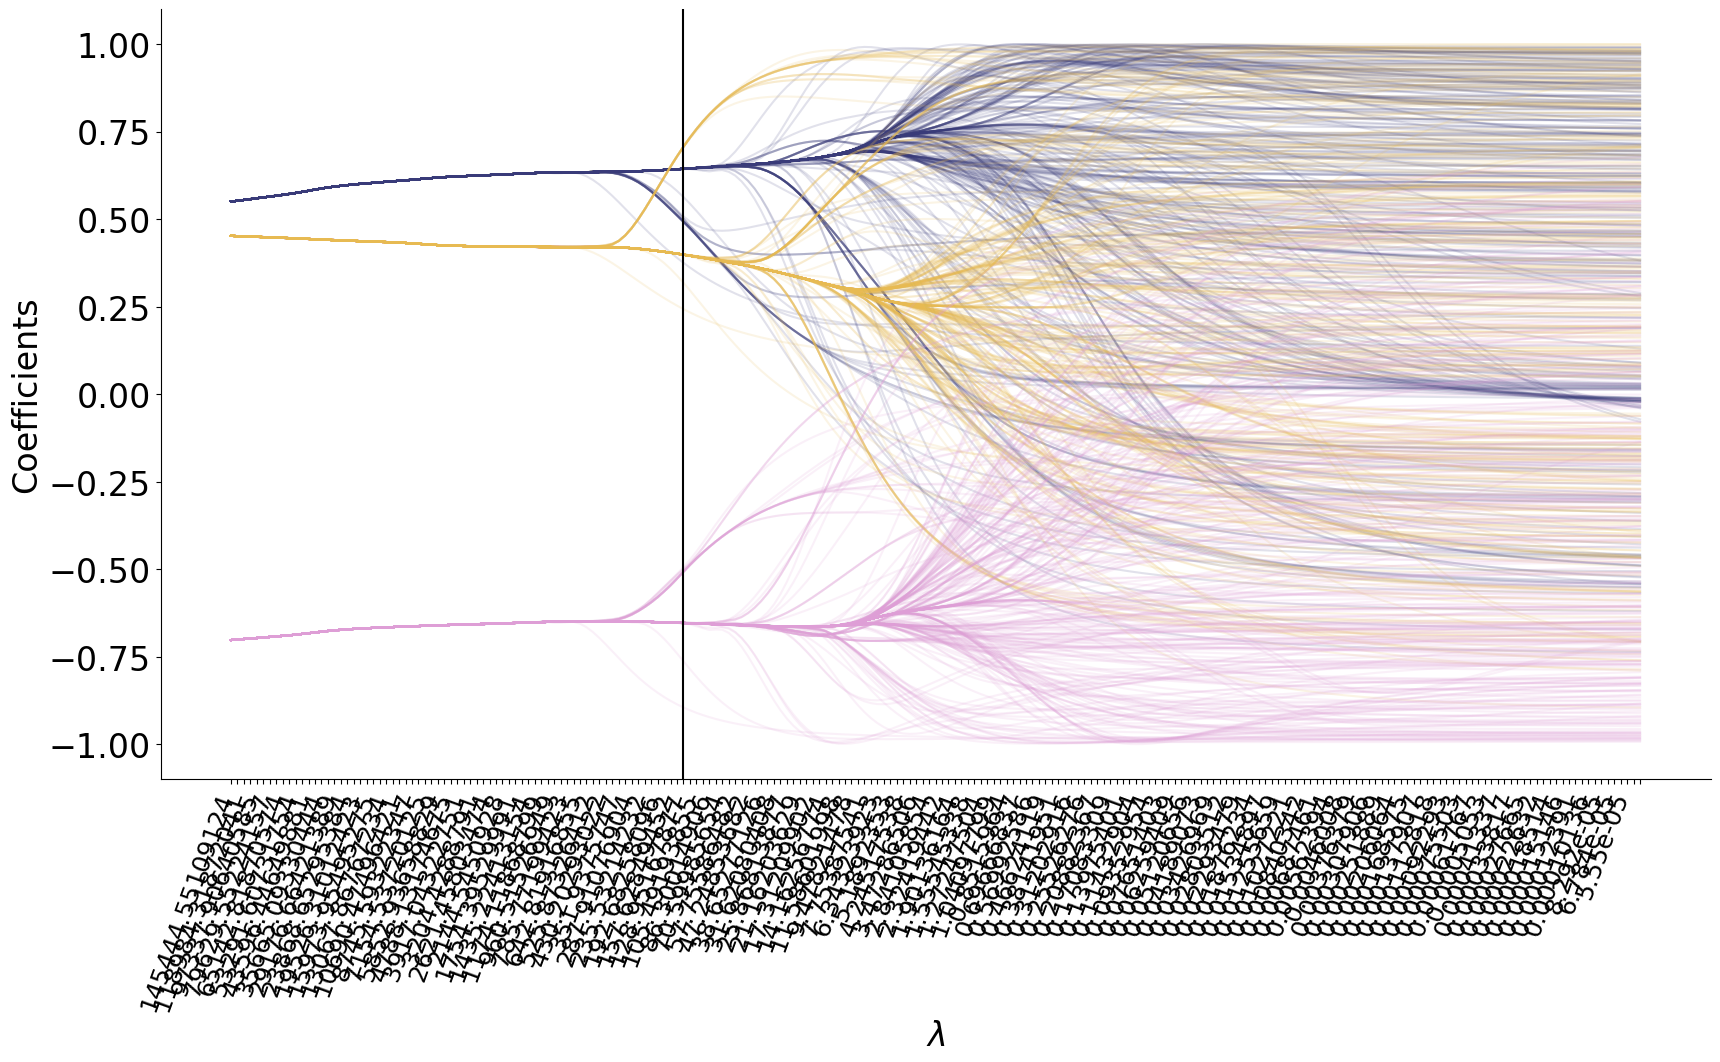

In [68]:
from matplotlib import cm
import seaborn as sns
def path_plot(coefficient_arr, penalty_list,plot_range=[0,-1],cut_vars=False, cmap='tab20b'):
    # Crop x axis (e.g, to remove 'burn-in' period at beginning)
    coefficient_arr = coefficient_arr[plot_range[0]:plot_range[1],:,:]
    penalty_list = penalty_list[plot_range[0]:plot_range[1]]
    if cut_vars is True:
        coefficient_arr = coefficient_arr[:,:,[1,2,coefficient_arr.shape[2]-1]]

    # Colormap
    cmap = cm.get_cmap(cmap, coefficient_arr.shape[2])
    colors = cmap(np.linspace(0.0,1.0,coefficient_arr.shape[2]))

    # Define x-axis range
    penalty_range = range(len(penalty_list))

    fig, ax = plt.subplots(1,1, figsize=(20,10))
    for i in range(coefficient_arr.shape[2]):
        x = np.round(np.array(penalty_list),8)[penalty_range]
        y = coefficient_arr[penalty_range,:,i]
        ax.plot(np.arange(x.shape[0]), y, color=colors[i], alpha=0.15)
        ax.set_xticks(range(x.shape[0]), minor=False);
        plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')
        ax.set_xticklabels(x,fontsize=24)
        evens = np.arange(0,len(ax.xaxis.get_ticklabels())+1,2)
    for label in ax.xaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.tick_params(axis='y', labelsize=24)
    ax.tick_params(axis='x', labelsize=18)

    plt.xlabel(r'$\lambda$',fontsize=24)
    plt.ylabel('Coefficients',fontsize=24)
    
start_idx = 40
choose_idx = 70

# Plot results for divisive clustering
path_plot(np.asarray(V_list), penalty_list, plot_range=[start_idx,-1])
plt.axvline(x=choose_idx, color='black')
sns.despine()


In [69]:
# clindat = np.delete(clinical_data1,297,axis=0)
# for var in range(3):
#     boxes = []
#     for label in np.unique(mode_clusters_new):
#         boxes.append(np.mean(np.nan_to_num(clindat[np.where(mode_clusters_new==label)[0]][:,var])))
#     print(boxes)


In [70]:
# clindat = np.delete(clinical_data1,297,axis=0)
# for var in range(3):
#     boxes = []
#     for label in np.unique(sc_new):
#         boxes.append(np.mean(np.nan_to_num(clindat[np.where(sc_new==label)[0]][:,var])))
#     print(boxes)


(298, 298)


/Users/logang/mambaforge/envs/pcae2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/logang/mambaforge/envs/pcae2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/logang/mambaforge/envs/pcae2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/logang/mambaforge/envs/pcae2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/logang/mambaforge/envs/pcae2/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not full

(array([75]),)

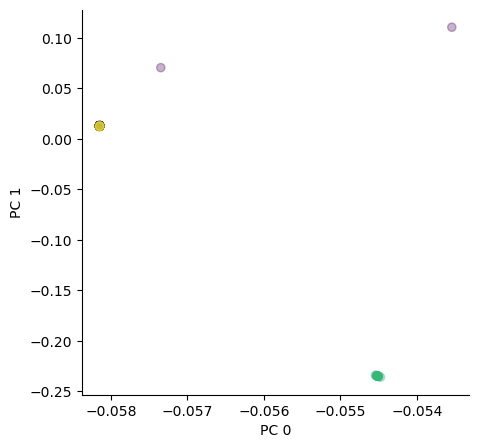

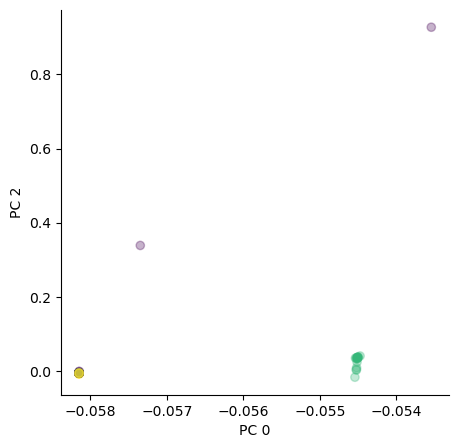

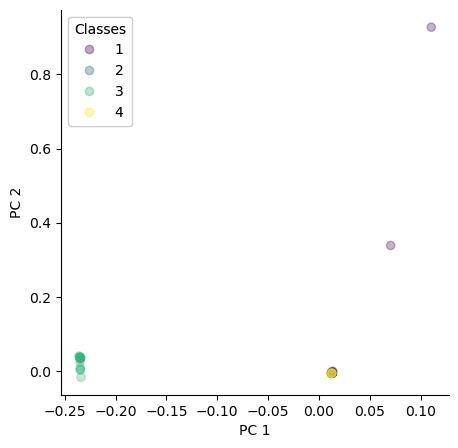

In [93]:
from sklearn.cluster import SpectralClustering
import seaborn as sns

def cluster_matching(pred, true):
    'New function for hungarian matching clusters'
    from sklearn.metrics import confusion_matrix, accuracy_score
    from scipy.optimize import linprog
    from scipy.optimize import linear_sum_assignment as linear_assignment
    def _make_cost_m(cm):
        s = np.max(cm)
        return (- cm + s)
    conf_mat = confusion_matrix(pred,true)
    indexes = linear_assignment(_make_cost_m(conf_mat))

    pred_new = np.copy(pred)
    for clusterN in range(len(np.unique(pred))):
        pred_new[pred==clusterN]= indexes[1][clusterN]

    return pred_new

A = V_list[start_idx+choose_idx]

sc_labels_list = []
for i in range(10):
    spectral_clustering = SpectralClustering(n_clusters=4, random_state=20, affinity="nearest_neighbors", assign_labels="cluster_qr").fit(A)
    sc_labels_list.append(spectral_clustering.labels_)
sc_labels = np.median(np.asarray(sc_labels_list),axis=0)

sc_new = cluster_matching(sc_labels, mode_clusters_new)

u,_,_ = np.linalg.svd(A)

print(u.shape)
plt.figure(figsize=(5,5))
plt.scatter(u[:,0],u[:,1], c=sc_new, alpha=0.3)
plt.xlabel('PC 0')
plt.ylabel('PC 1')
sns.despine()

plt.figure(figsize=(5,5))
plt.scatter(u[:,0],u[:,2], c=sc_new, alpha=0.3)
plt.xlabel('PC 0')
plt.ylabel('PC 2')
sns.despine()

fig, ax = plt.subplots(figsize=(5,5))
scatter = plt.scatter(u[:,1],u[:,2], c=sc_new, alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
sns.despine()

np.where(u[:,1]==np.min(u[:,1]))

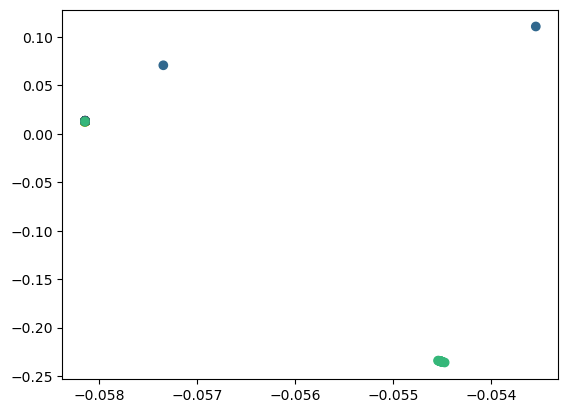

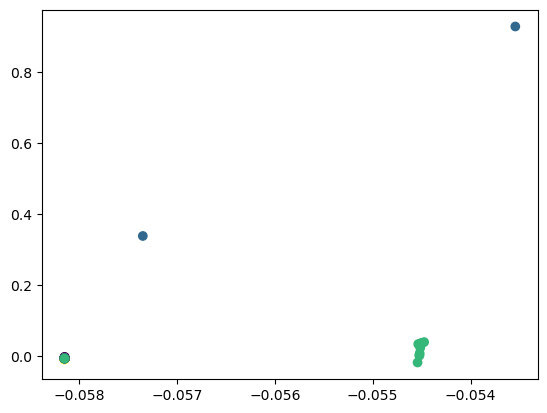

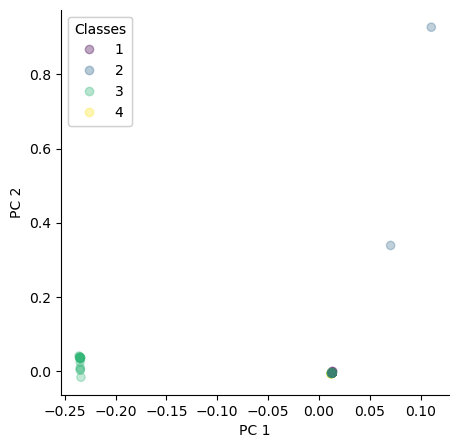

In [94]:
plt.figure()
plt.scatter(u[:,0],u[:,1], c=mode_clusters_new)

plt.figure()
plt.scatter(u[:,0],u[:,2], c=mode_clusters_new)

fig, ax = plt.subplots(figsize=(5,5))
scatter = plt.scatter(u[:,1], u[:,2], c=mode_clusters_new, alpha=0.3)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
sns.despine()

Normalized confusion matrix
Average Accuracy: 0.607180961757927
[[0.73913043 0.04347826 0.         0.2173913 ]
 [0.16091954 0.6091954  0.         0.22988506]
 [0.25373134 0.17910448 0.25373134 0.31343284]
 [0.08       0.09333333 0.         0.82666667]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='P3CA label', ylabel='Buch et al. 2023 label'>

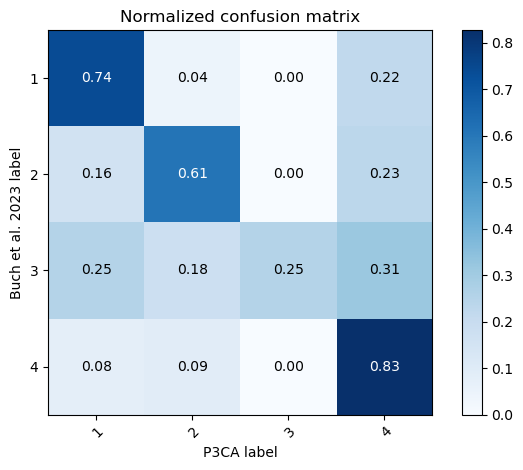

In [95]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, 
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.unique(y_true)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Print average accuracy
    print("Average Accuracy:", np.mean(np.diag(cm)))
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Buch et al. 2023 label',
           xlabel='P3CA label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(np.unique(y_true))-0.5)
    plt.ylim(len(np.unique(y_true))-0.5, -0.5)
    return ax

plot_confusion_matrix(mode_clusters_new, sc_new)


# 